In [1]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training

BATCH_SIZE = 128

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("/home/nick/dbox/EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

/home/nick/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Compacting    2430
Blastocyst    2246
2pn           2015
Empty         1423
Syngamy       1174
2 Cell        1087
4 Cell         951
8 Cell         469
6 Cell         446
3 Cell         374
9 Cell+        244
5 Cell         215
Name: class, dtype: int64

<AxesSubplot:>

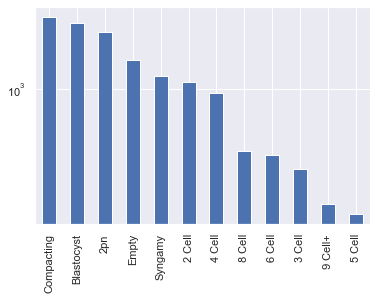

In [2]:
df["class"].value_counts().plot.bar(logy=True)

In [3]:
class_counts = df["class"].value_counts()
#mask = ~df["class"].isin(class_counts[class_counts > 10].index)
#df["class"][mask] = "Other"

In [11]:
#df["class"][~df["class"].isin(["Empty", "Morula"])] = "Other"
# Build training and validation dataframes. This gives us fine control over what we use for train & test
train_rows = []
validation_rows = []
for c in df["class"].unique():
    df_for_class = df[df["class"] == c].copy()
    if len(df_for_class) > 20:
        validation_sample = df_for_class.sample(min(round(.2*len(df_for_class)),500))
        validation_rows.append(validation_sample)
        train_sample = df_for_class.drop(validation_sample.index)
        # Accounting for training class imbalance
        # still leaving 20%. Might need more sophisticated f(x) here for class imbalance.
        train_sample = train_sample.sample(min(len(train_sample), round(len(df_for_class)),2000))
        train_rows.append(train_sample)
train_df = pd.concat(train_rows)
validation_df = pd.concat(validation_rows)
display(df)
display(train_df["class"].value_counts())
validation_df = validation_df.sample(frac=1)
display(validation_df["class"].value_counts())

,filename,class
0,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M0776_S00635_W1_F0_1903.jpg,2 Cell
1,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M0831_S00479_W3_F0_1642.jpg,2 Cell
2,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M3169_S00737_W2_F0_2056.jpg,2 Cell
3,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M776_S0087_W5_F0_2115.jpg,2 Cell
4,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M0776_S00761_W3_F0_1827.jpg,2 Cell
...,...,...
239,/home/nick/dbox/EmbryoLabeling/Labelers/train/9 Cell+/M0831_S00479_W3_F0_3943.jpg,9 Cell+
240,/home/nick/dbox/EmbryoLabeling/Labelers/train/9 Cell+/M0831_S00470_W5_F0_7311.jpg,9 Cell+
241,/home/nick/dbox/EmbryoLabeling/Labelers/train/9 Cell+/M0831_S00470_W5_F0_6646.jpg,9 Cell+
242,/home/nick/dbox/EmbryoLabeling/Labelers/train/9 Cell+/M0831_S00479_W1_F0_3782.jpg,9 Cell+


Compacting    1944
Blastocyst    1797
2pn           1612
Empty         1138
Syngamy        939
2 Cell         870
4 Cell         761
8 Cell         375
6 Cell         357
3 Cell         299
9 Cell+        195
5 Cell         172
Name: class, dtype: int64

Compacting    486
Blastocyst    449
2pn           403
Empty         285
Syngamy       235
2 Cell        217
4 Cell        190
8 Cell         94
6 Cell         89
3 Cell         75
9 Cell+        49
5 Cell         43
Name: class, dtype: int64

In [12]:

datagen = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
)


training = datagen.flow_from_dataframe(train_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=True)

# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
validation = datagen.flow_from_dataframe(validation_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)

Found 10459 validated image filenames belonging to 12 classes.
Found 2615 validated image filenames belonging to 12 classes.


In [13]:
assert training.class_indices == validation.class_indices

In [14]:
list(training.class_indices.keys())

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 '9 Cell+',
 'Blastocyst',
 'Compacting',
 'Empty',
 'Syngamy']

In [15]:
code2class = {v:k for k, v in training.class_indices.items()}
code2class

{0: '2 Cell',
 1: '2pn',
 2: '3 Cell',
 3: '4 Cell',
 4: '5 Cell',
 5: '6 Cell',
 6: '8 Cell',
 7: '9 Cell+',
 8: 'Blastocyst',
 9: 'Compacting',
 10: 'Empty',
 11: 'Syngamy'}

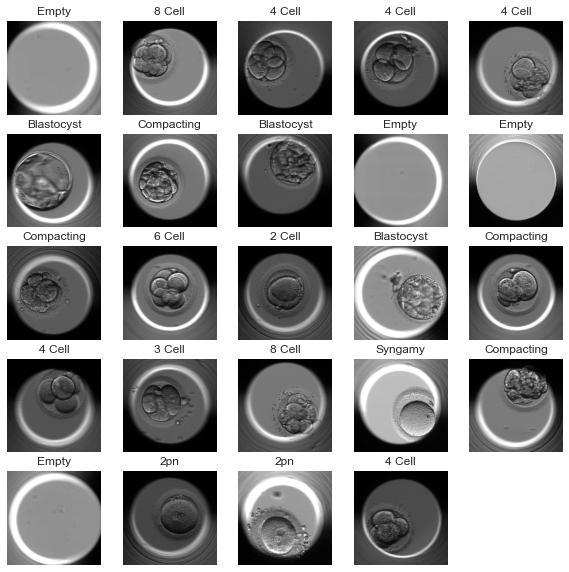

In [16]:
plt.figure(figsize=(10, 10))
images, labels = next(training)
for i in range(24):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i]/255)
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

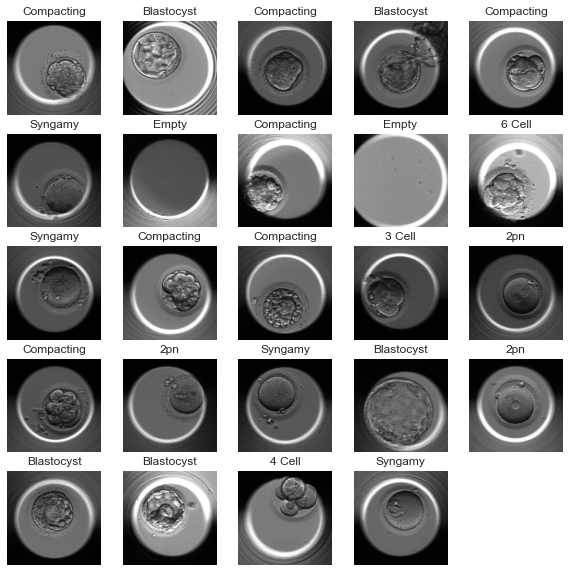

In [17]:
plt.figure(figsize=(10, 10))
images, labels = next(validation)
for i in range(min(24, len(labels))):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i]/255)
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

In [18]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1./127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(len(code2class), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

2022-06-14 12:12:30.722030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-14 12:12:31.514688: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8930 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:42:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [19]:
%%time
training.reset()
validation.reset()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)


CPU times: user 16.7 ms, sys: 57 µs, total: 16.7 ms
Wall time: 15.7 ms


In [20]:

history = model.fit(training,
                    epochs=500,
                    verbose=0, # TQDMProgressBar logs out the info, so no need for the default logs
                    validation_data=validation,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='loss',patience=5, verbose=0),
                        tfa.callbacks.TQDMProgressBar()
                    ])

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/82           ETA: ?s - 

2022-06-14 12:12:53.603435: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


Epoch 2/500


0/82           ETA: ?s - 

Epoch 3/500


0/82           ETA: ?s - 

Epoch 4/500


0/82           ETA: ?s - 

Epoch 5/500


0/82           ETA: ?s - 

Epoch 6/500


0/82           ETA: ?s - 

Epoch 7/500


0/82           ETA: ?s - 

Epoch 8/500


0/82           ETA: ?s - 

Epoch 9/500


0/82           ETA: ?s - 

Epoch 10/500


0/82           ETA: ?s - 

Epoch 11/500


0/82           ETA: ?s - 

Epoch 12/500


0/82           ETA: ?s - 

Epoch 13/500


0/82           ETA: ?s - 

Epoch 14/500


0/82           ETA: ?s - 

Epoch 15/500


0/82           ETA: ?s - 

Epoch 16/500


0/82           ETA: ?s - 

Epoch 17/500


0/82           ETA: ?s - 

Epoch 18/500


0/82           ETA: ?s - 

Epoch 19/500


0/82           ETA: ?s - 

Epoch 20/500


0/82           ETA: ?s - 

Epoch 21/500


0/82           ETA: ?s - 

Epoch 22/500


0/82           ETA: ?s - 

Epoch 23/500


0/82           ETA: ?s - 

Epoch 24/500


0/82           ETA: ?s - 

Epoch 25/500


0/82           ETA: ?s - 

Epoch 26/500


0/82           ETA: ?s - 

Epoch 27/500


0/82           ETA: ?s - 

Epoch 28/500


0/82           ETA: ?s - 

Epoch 29/500


0/82           ETA: ?s - 

Epoch 30/500


0/82           ETA: ?s - 

Epoch 31/500


0/82           ETA: ?s - 

Epoch 32/500


0/82           ETA: ?s - 

Epoch 33/500


0/82           ETA: ?s - 

Epoch 34/500


0/82           ETA: ?s - 

Epoch 35/500


0/82           ETA: ?s - 

Epoch 36/500


0/82           ETA: ?s - 

Epoch 37/500


0/82           ETA: ?s - 

Epoch 38/500


0/82           ETA: ?s - 

Epoch 39/500


0/82           ETA: ?s - 

Epoch 40/500


0/82           ETA: ?s - 

Epoch 41/500


0/82           ETA: ?s - 

Epoch 42/500


0/82           ETA: ?s - 

Epoch 43/500


0/82           ETA: ?s - 

Epoch 44/500


0/82           ETA: ?s - 

Epoch 45/500


0/82           ETA: ?s - 

<AxesSubplot:>

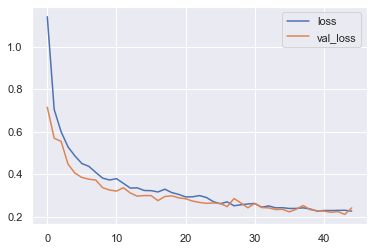

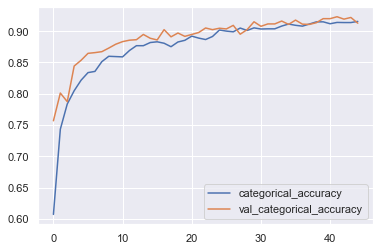

In [21]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [22]:
y_pred = model.predict(validation)

21/21 [==============================] - 9s 392ms/step


In [23]:
predicted_codes = y_pred.argmax(axis=1)
confidence = pd.Series(y_pred.max(axis=1))
confidence.describe()

count    2615.000000
mean        0.923612
std         0.137260
min         0.229246
25%         0.920886
50%         0.993007
75%         0.999837
max         1.000000
dtype: float64

In [24]:
validation_df["predicted_class"] = [code2class[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

,filename,class,predicted_class,confidence
2420,/home/nick/dbox/EmbryoLabeling/Labelers/train/Compacting/M0776_S00635_W7_F0_5005.jpg,Compacting,Compacting,0.840721
925,/home/nick/dbox/EmbryoLabeling/Labelers/train/Blastocyst/M3169_S00668_W5_F0_5512.jpg,Blastocyst,Blastocyst,1.000000
2378,/home/nick/dbox/EmbryoLabeling/Labelers/train/Compacting/M0776_S00761_W3_F0_5020.jpg,Compacting,Compacting,0.916251
1316,/home/nick/dbox/EmbryoLabeling/Labelers/train/Blastocyst/M0776_S00534_W1_F0_8346.jpg,Blastocyst,Blastocyst,1.000000
1825,/home/nick/dbox/EmbryoLabeling/Labelers/train/Compacting/M776_S0087_W6_F0_3666.jpg,Compacting,Compacting,0.710792
...,...,...,...,...
1848,/home/nick/dbox/EmbryoLabeling/Labelers/train/Blastocyst/M0776_S00761_W4_F0_5660.jpg,Blastocyst,Compacting,1.000000
934,/home/nick/dbox/EmbryoLabeling/Labelers/train/2pn/M0776_S00635_W7_F0_1104.jpg,2pn,2pn,0.992098
441,/home/nick/dbox/EmbryoLabeling/Labelers/train/8 Cell/M0776_S00534_W3_F0_3049.jpg,8 Cell,8 Cell,0.369972
411,/home/nick/dbox/EmbryoLabeling/Labelers/train/2pn/M0776_S00761_W6_F0_1173.jpg,2pn,Syngamy,0.770255


In [25]:
validation_df.groupby("class").confidence.median()

class
2 Cell        0.993323
2pn           0.992060
3 Cell        0.988214
4 Cell        0.993126
5 Cell        0.993761
6 Cell        0.994998
8 Cell        0.992907
9 Cell+       0.997038
Blastocyst    0.992016
Compacting    0.993553
Empty         0.994998
Syngamy       0.995176
Name: confidence, dtype: float32

              precision    recall  f1-score   support

      2 Cell       0.90      0.90      0.90       217
         2pn       0.98      0.84      0.91       403
      3 Cell       0.88      0.71      0.79        75
      4 Cell       0.83      0.94      0.88       190
      5 Cell       0.79      0.51      0.62        43
      6 Cell       0.83      0.75      0.79        89
      8 Cell       0.79      0.66      0.72        94
     9 Cell+       0.98      0.90      0.94        49
  Blastocyst       0.98      0.96      0.97       449
  Compacting       0.89      0.96      0.92       486
       Empty       1.00      1.00      1.00       285
     Syngamy       0.77      0.97      0.86       235

    accuracy                           0.91      2615
   macro avg       0.89      0.84      0.86      2615
weighted avg       0.91      0.91      0.91      2615



Text(30.453125, 0.5, 'True')

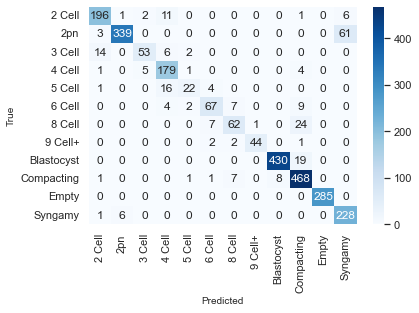

In [26]:
print(classification_report(validation_df["class"], validation_df["predicted_class"]))
labels = list(training.class_indices.keys())
s = sns.heatmap(
    confusion_matrix(validation_df["class"], validation_df["predicted_class"]),
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=labels,
    yticklabels=labels
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [20]:
model.save(f"models/dense_{len(code2class)}_class.h5")